<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Deep_Learning/wobNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
#!pip install -q git+https://github.com/deepmind/dm-haiku
#!pip install -q optax

haiku documentation: https://dm-haiku.readthedocs.io/en/latest/api.html

optax documentation: https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html

tutorial: https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-guide-to-create-multi-layer-perceptrons-using-jax

haiku example: https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py 

In [117]:
import haiku as hk
import optax
import jax.numpy as jnp
import numpy as np
import jax
import jax.lax as lax

import matplotlib.pyplot as plt

# Data

In [118]:
def getData():
  data = np.load('drive/MyDrive/wob_piecwise_data.npz')
  return data['x'], data['y']

In [119]:
def test_train_split(x, y, train_percentage=0.8):
  x = jnp.array(x)
  y = jnp.array(y)

  sample_size, dimensions = x.shape

  split_index = int(jnp.ceil(sample_size * train_percentage))

  x_train = x[:split_index]
  y_train = y[:split_index]
  x_test = x[split_index:]
  y_test = y[split_index:]

  return x_train, y_train, x_test, y_test

In [120]:
def fast_data(x_train, y_train, epochs=1, batch_size=1):
  x_train_fast, y_train_fast = x_train, y_train

  extra = len(x_train_fast) % batch_size
  if extra != 0:
    x_train_fast = x_train_fast[:-extra]
    y_train_fast = y_train_fast[:-extra]

  batches = int(len(x_train_fast)/batch_size)
  x_train_fast = jnp.reshape(x_train_fast, (batches, batch_size, jnp.size(x_train_fast, 1)))
  y_train_fast = jnp.reshape(y_train_fast, (batches, batch_size, 1))

  x_train_fast = jnp.tile(x_train_fast, (epochs,1,1))
  y_train_fast = jnp.tile(y_train_fast, (epochs,1,1))
  return x_train_fast, y_train_fast

In [121]:
x, y = getData()
x_train, y_train, x_test, y_test = test_train_split(x, y)

# Network

In [122]:
def netFn(x):
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(50), jax.nn.relu,
      hk.Linear(10), jax.nn.relu,
      hk.Linear(1),
  ])
  return mlp(x)

In [123]:
lr = 1e-3
key = jax.random.PRNGKey(0)

network = hk.without_apply_rng(hk.transform(netFn))
optimizer = optax.adam(lr)

In [124]:
params = network.init(key, x_train[0])
opt_state = optimizer.init(params)

In [125]:
@jax.jit
def predict(params, input_data):
  preds = network.apply(params, input_data)
  return preds

In [126]:
@jax.jit
def loss(params, input_data, actual):
  preds = predict(params, input_data)
  return jnp.power(actual - preds, 2).mean()

In [127]:
@jax.jit
def update(params, opt_state, input_data, actual_data):
  loss_value, grads = jax.value_and_grad(loss, 0)(params, input_data, actual_data)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return loss_value, params, opt_state

# Training

In [128]:
def training_scan_loop(state, input_data):
  train_loss, params, opt_state = update(state[0], state[1], input_data[0], input_data[1])
  #return (params, opt_state), train_loss
  test_loss = loss(state[0], x_test, y_test)
  return (params, opt_state), (train_loss, test_loss)

In [129]:
@jax.jit
def train_fast(params, opt_state, x_train_fast, y_train_fast):
  init_state = (params, opt_state)
  input_data = (x_train_fast, y_train_fast)
  final_state, loss_array = lax.scan(training_scan_loop, init_state, input_data)
  return final_state[0], final_state[1], loss_array

def train_normal(params, opt_state, epochs, batch_size):
  for i in range(epochs):
    for j in range(0, len(x_train), batch_size):
      train_loss, params, opt_state = update(params, opt_state, 
                                             x_train[j:j+batch_size], 
                                             y_train[j:j+batch_size])
    if (i % 100 == 0):
      test_loss = loss(params, x_test, y_test)
      print('loss:', test_loss)
  return params, opt_state

In [130]:
%%time
#params, opt_state = train_normal(params, opt_state, epochs=500, batch_size=100)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [131]:
%%time
'''
Hyper-parameters to study.
more important:
- epochs
- batch_size
- x_train size
- y_train accuracy (basically change wob sample_size)
- neural network architecture (layers, activation functions, neurons, etc...)

less important:
- learning_rate
- different optimizers (sgd, adam, etc...)
- different loss functions
'''
epochs = 500
batch_size = 100
x_train_fast, y_train_fast = fast_data(x_train, y_train, epochs, batch_size)
params, opt_state, loss_array = train_fast(params, opt_state, x_train_fast, y_train_fast)

CPU times: user 5.85 s, sys: 13.7 ms, total: 5.86 s
Wall time: 5.86 s


# Loss

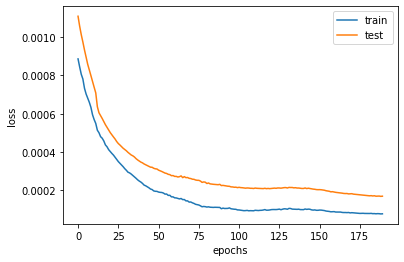

In [138]:
epoch_start = 10
epoch_end = 200
batches_per_epoch = int(len(loss_array[0]) / epochs)

epoch_axis = jnp.arange(epoch_end-epoch_start)
train_loss = loss_array[0][::batches_per_epoch][epoch_start:epoch_end]
test_loss = loss_array[1][::batches_per_epoch][epoch_start:epoch_end]


plt.plot(epoch_axis, train_loss, label='train')
plt.plot(epoch_axis, test_loss, label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Error

In [133]:
def trueSoln(p):
  return 0.5 + np.arctan(2*p[1]/(1-np.power(p[0],2)-np.power(p[1],2)))/np.pi

In [134]:
from scipy.interpolate import LinearNDInterpolator

def graph_mesh(x_points, y_points, z_points, resolution=50):
  X = np.linspace(-1, 1, resolution)
  Y = np.linspace(-1, 1, resolution)
  X, Y = np.meshgrid(X, Y)
  interp = LinearNDInterpolator(list(zip(x_points, y_points)), z_points)
  Z = interp(X, Y)
  plt.pcolormesh(X, Y, Z, shading='auto')
  plt.colorbar()

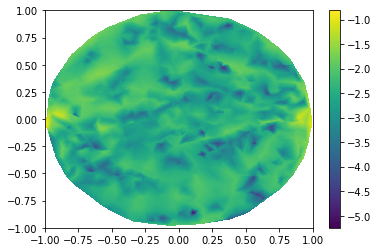

In [135]:
error = jnp.abs(predict(params, x_test)[:,0] - trueSoln(x_test.T))
#print('mean', error.mean())
#print('std', error.std())
#print('median', jnp.median(error))
#plt.scatter(x_test[:,0], x_test[:,1], c=jnp.log10(error))
graph_mesh(x_test[:,0], x_test[:,1], jnp.log10(error), resolution=1000)

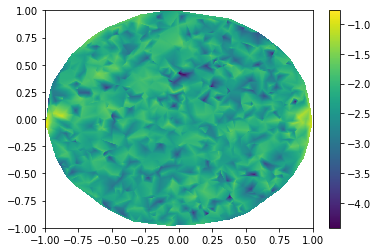

In [136]:
error = jnp.abs(predict(params, x_test)[:,0] - y_test[:,0])
#print('mean', error.mean())
#print('std', error.std())
#print('median', jnp.median(error))
#plt.scatter(x_test[:,0], x_test[:,1], c=jnp.log10(error))
#plt.colorbar()
graph_mesh(x_test[:,0], x_test[:,1], jnp.log10(error), resolution=1000)

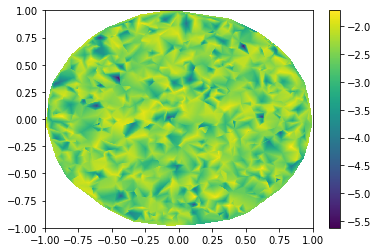

In [137]:
error = jnp.abs(trueSoln(x_test.T) - y_test[:,0])
#print('mean', error.mean())
#print('std', error.std())
#print('median', jnp.median(error))
#plt.scatter(x_test[:,0], x_test[:,1], c=jnp.log10(error))
#plt.colorbar()
graph_mesh(x_test[:,0], x_test[:,1], jnp.log10(error), resolution=1000)